# 01.2 Association vs. Causation: The Bias Equation

**Chapter**: 1 - Introduction to Causality  
**Section**: 2 - Association vs. Causation  
**Facure Source**: 01-Introduction-To-Causality.ipynb  
**Version**: 1.0.0  
**Last Validated**: 2026-01-09

---

## Table of Contents

1. [Facure's Intuition](#1-facures-intuition)
   - 1.1 [The Core Confusion](#11-the-core-confusion)
   - 1.2 [Why Naive Comparison Fails](#12-why-naive-comparison-fails)
2. [Formal Treatment](#2-formal-treatment)
   - 2.1 [The Bias Decomposition](#21-the-bias-decomposition)
   - 2.2 [When Association Equals Causation](#22-when-association-equals-causation)
3. [Numeric Demonstration](#3-numeric-demonstration)
   - 3.1 [Computing Bias Explicitly](#31-computing-bias-explicitly)
   - 3.2 [Visualizing the Bias Problem](#32-visualizing-the-bias-problem)
4. [Implementation](#4-implementation)
5. [Interview Appendix](#5-interview-appendix)
6. [References](#6-references)

---

In [1]:
# Standard imports via common module
import sys
sys.path.insert(0, '../..')

from facure_augment.common import (
    np, pd, plt, sm,
    set_notebook_style,
    create_tufte_figure,
    TUFTE_PALETTE,
)

set_notebook_style()
np.random.seed(42)

---

## 1. Facure's Intuition

> **Interview Relevance**: The bias decomposition equation is perhaps the most important formula in causal inference. If you can derive and explain it, you understand the core challenge.

### 1.1 The Core Confusion

Facure's memorable analogy: **Association is not causation** is something your parents probably repeated to you. But *why* isn't it?

Consider: "Schools with tablets have higher test scores."

**Naive interpretation**: Tablets cause higher scores.

**Problem**: Schools with tablets are probably *wealthier*. They'd have higher scores *even without tablets* because they have:
- Better teachers
- More resources
- Students from higher-income families

The observed difference conflates:
1. The actual effect of tablets
2. Pre-existing differences between schools

### 1.2 Why Naive Comparison Fails

When we compare $E[Y|T=1] - E[Y|T=0]$, we're comparing **different populations**:

- Treated: Wealthy schools (chose tablets)
- Control: Less wealthy schools (didn't choose tablets)

These groups differ in ways beyond just the treatment. The selection into treatment is **non-random**.

★ Insight ─────────────────────────────────────
- **Selection bias** = treated and control differ *before* treatment
- The bias reflects $E[Y_0|T=1] - E[Y_0|T=0]$
- This is what Facure calls "the baseline difference"
─────────────────────────────────────────────────

---

## 2. Formal Treatment

### 2.1 The Bias Decomposition

This is the **most important equation** in causal inference. Memorize it.

**Association** (what we observe):
$$E[Y|T=1] - E[Y|T=0]$$

**Causation** (what we want):
$$\text{ATE} = E[Y_1 - Y_0]$$

**Derivation**: Start with association and substitute potential outcomes.

For treated: $Y = Y_1$ when $T=1$  
For control: $Y = Y_0$ when $T=0$

$$E[Y|T=1] - E[Y|T=0] = E[Y_1|T=1] - E[Y_0|T=0]$$

Now, add and subtract $E[Y_0|T=1]$ (the counterfactual for the treated):

$$= E[Y_1|T=1] - E[Y_0|T=1] + E[Y_0|T=1] - E[Y_0|T=0]$$

$$= \underbrace{E[Y_1 - Y_0|T=1]}_{\text{ATT}} + \underbrace{\{E[Y_0|T=1] - E[Y_0|T=0]\}}_{\text{BIAS}}$$

**The Bias Decomposition**:
$$\boxed{\text{Association} = \text{ATT} + \text{BIAS}}$$

where:
- **ATT** = effect of treatment on the treated
- **BIAS** = baseline difference between treated and control *in the absence of treatment*

### 2.2 When Association Equals Causation

Association = Causation if and only if **BIAS = 0**.

**Bias = 0** means:
$$E[Y_0|T=1] = E[Y_0|T=0]$$

In words: the untreated potential outcome is the same regardless of treatment assignment.

**This is the exchangeability assumption**:
$$Y_0 \perp T$$

Under exchangeability:
1. Treated and control are comparable at baseline
2. Treatment assignment is "as good as random"
3. No confounding

**Full exchangeability** (also $Y_1 \perp T$) gives:
$$\text{Association} = \text{ATT} = \text{ATE}$$

| Assumption | Formula | Implication |
|------------|---------|-------------|
| None | $E[Y\|T=1] - E[Y\|T=0]$ | Association only |
| $Y_0 \perp T$ | Association = ATT | Identifies treated effect |
| $(Y_0, Y_1) \perp T$ | Association = ATT = ATE | Identifies population effect |

---

## 3. Numeric Demonstration

### 3.1 Computing Bias Explicitly

In [2]:
# Using our schools example with God's-eye view
schools = pd.DataFrame({
    'school_id': [1, 2, 3, 4],
    'Y0': [500, 600, 800, 700],  # Without tablets
    'Y1': [450, 600, 600, 750],  # With tablets
    'T':  [0, 0, 1, 1],
})
schools['Y_obs'] = np.where(schools['T'] == 1, schools['Y1'], schools['Y0'])

print("Data with both potential outcomes (God's view):")
print(schools.to_string(index=False))

Data with both potential outcomes (God's view):
 school_id  Y0  Y1  T  Y_obs
         1 500 450  0    500
         2 600 600  0    600
         3 800 600  1    600
         4 700 750  1    750


In [3]:
# Calculate each component of the bias decomposition

# Association: E[Y|T=1] - E[Y|T=0]
association = schools.query('T == 1')['Y_obs'].mean() - \
              schools.query('T == 0')['Y_obs'].mean()

# ATT: E[Y1 - Y0 | T=1]
att = (schools.query('T == 1')['Y1'] - schools.query('T == 1')['Y0']).mean()

# Bias: E[Y0|T=1] - E[Y0|T=0]
bias = schools.query('T == 1')['Y0'].mean() - schools.query('T == 0')['Y0'].mean()

# ATE: E[Y1 - Y0] over all units
ate = (schools['Y1'] - schools['Y0']).mean()

print("BIAS DECOMPOSITION")
print("="*60)
print(f"Association = E[Y|T=1] - E[Y|T=0]  = {association:+.1f}")
print(f"ATT         = E[Y1 - Y0 | T=1]     = {att:+.1f}")
print(f"Bias        = E[Y0|T=1] - E[Y0|T=0] = {bias:+.1f}")
print()
print(f"Verification: Association = ATT + Bias?")
print(f"              {association:.1f} = {att:.1f} + {bias:.1f} = {att + bias:.1f} ✓")
print()
print(f"True ATE    = E[Y1 - Y0]           = {ate:+.1f}")

BIAS DECOMPOSITION
Association = E[Y|T=1] - E[Y|T=0]  = +125.0
ATT         = E[Y1 - Y0 | T=1]     = -75.0
Bias        = E[Y0|T=1] - E[Y0|T=0] = +200.0

Verification: Association = ATT + Bias?
              125.0 = -75.0 + 200.0 = 125.0 ✓

True ATE    = E[Y1 - Y0]           = -50.0


**Interpretation**:

1. **Association = +125**: Schools with tablets score 125 points higher (on average)
2. **ATT = -75**: But tablets actually *hurt* treated schools by 75 points
3. **Bias = +200**: Treated schools would score 200 points higher *even without tablets*

The positive bias (wealthy schools selecting into treatment) completely overwhelms and reverses the negative treatment effect!

### 3.2 Visualizing the Bias Problem

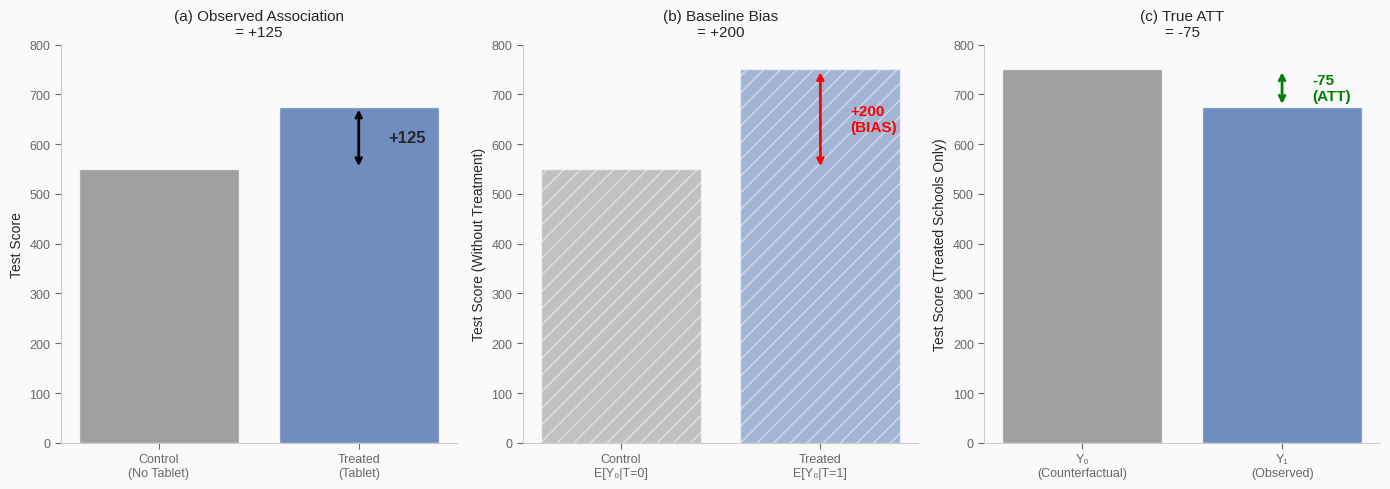


THE BIAS EQUATION:
Association (+125) = ATT (-75) + Bias (+200)


In [4]:
# Create visualization showing the bias decomposition
fig, axes = create_tufte_figure(1, 3, figsize=(14, 5))

# Panel 1: What we observe (Association)
ax = axes[0]
means = [schools.query('T == 0')['Y_obs'].mean(),
         schools.query('T == 1')['Y_obs'].mean()]
bars = ax.bar(['Control\n(No Tablet)', 'Treated\n(Tablet)'], means,
              color=[TUFTE_PALETTE['control'], TUFTE_PALETTE['treatment']],
              alpha=0.8, edgecolor='white')
ax.set_ylabel('Test Score')
ax.set_title(f'(a) Observed Association\n= {association:+.0f}')
ax.set_ylim(0, 800)

# Add arrow showing difference
ax.annotate('', xy=(1, means[1]), xytext=(1, means[0]),
            arrowprops=dict(arrowstyle='<->', color='black', lw=2))
ax.text(1.15, (means[0] + means[1])/2, f'+{association:.0f}', 
        va='center', fontsize=12, fontweight='bold')

# Panel 2: Bias (baseline difference)
ax = axes[1]
y0_means = [schools.query('T == 0')['Y0'].mean(),
            schools.query('T == 1')['Y0'].mean()]
bars = ax.bar(['Control\nE[Y₀|T=0]', 'Treated\nE[Y₀|T=1]'], y0_means,
              color=[TUFTE_PALETTE['control'], TUFTE_PALETTE['treatment']],
              alpha=0.5, edgecolor='white', hatch='//')
ax.set_ylabel('Test Score (Without Treatment)')
ax.set_title(f'(b) Baseline Bias\n= {bias:+.0f}')
ax.set_ylim(0, 800)

# Add arrow showing bias
ax.annotate('', xy=(1, y0_means[1]), xytext=(1, y0_means[0]),
            arrowprops=dict(arrowstyle='<->', color='red', lw=2))
ax.text(1.15, (y0_means[0] + y0_means[1])/2, f'+{bias:.0f}\n(BIAS)', 
        va='center', fontsize=11, color='red', fontweight='bold')

# Panel 3: True treatment effect (ATT)
ax = axes[2]
treated = schools.query('T == 1')
ax.bar(['Y₀\n(Counterfactual)', 'Y₁\n(Observed)'], 
       [treated['Y0'].mean(), treated['Y1'].mean()],
       color=[TUFTE_PALETTE['control'], TUFTE_PALETTE['treatment']],
       alpha=0.8, edgecolor='white')
ax.set_ylabel('Test Score (Treated Schools Only)')
ax.set_title(f'(c) True ATT\n= {att:+.0f}')
ax.set_ylim(0, 800)

# Add arrow showing ATT
ax.annotate('', xy=(1, treated['Y1'].mean()), xytext=(1, treated['Y0'].mean()),
            arrowprops=dict(arrowstyle='<->', color='green', lw=2))
ax.text(1.15, (treated['Y0'].mean() + treated['Y1'].mean())/2, 
        f'{att:+.0f}\n(ATT)', va='center', fontsize=11, color='green', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("THE BIAS EQUATION:")
print(f"Association ({association:+.0f}) = ATT ({att:+.0f}) + Bias ({bias:+.0f})")
print("="*60)

In [5]:
# Simulate what happens under randomization (bias = 0)
np.random.seed(123)
n = 1000

# Generate potential outcomes (same for everyone regardless of treatment)
Y0 = np.random.normal(600, 100, n)
tau = np.random.normal(-50, 30, n)  # Negative treatment effect
Y1 = Y0 + tau

# RANDOMIZED treatment assignment
T = np.random.binomial(1, 0.5, n)

# Observed outcomes
Y = np.where(T == 1, Y1, Y0)

# Compute components
association_rct = Y[T == 1].mean() - Y[T == 0].mean()
bias_rct = Y0[T == 1].mean() - Y0[T == 0].mean()
att_rct = tau[T == 1].mean()
ate_rct = tau.mean()

print("UNDER RANDOMIZATION (n=1000)")
print("="*60)
print(f"Association = {association_rct:+.2f}")
print(f"ATT         = {att_rct:+.2f}")
print(f"Bias        = {bias_rct:+.2f} (≈ 0 by randomization!)")
print(f"True ATE    = {ate_rct:+.2f}")
print()
print("With randomization:")
print(f"  Association ≈ ATT ≈ ATE ✓")
print(f"  The naive comparison WORKS!")

UNDER RANDOMIZATION (n=1000)
Association = -61.28
ATT         = -50.54
Bias        = -10.74 (≈ 0 by randomization!)
True ATE    = -49.75

With randomization:
  Association ≈ ATT ≈ ATE ✓
  The naive comparison WORKS!


---

## 4. Implementation

The bias decomposition is primarily a diagnostic tool for understanding when estimates are valid:

```python
# Diagnostic check: is treatment assignment balanced?
from causal_inference.diagnostics import balance_check

balance = balance_check(
    covariates=data[['income', 'prior_score', 'location']],
    treatment=data['tablet']
)

# If SMD (standardized mean difference) > 0.1, bias likely exists
print(balance.summary())
```

**When bias is detected**, use methods from later chapters:
- **Regression adjustment** (Chapter 5)
- **Propensity score matching** (Chapter 11)
- **Instrumental variables** (Chapter 8)
- **Difference-in-differences** (Chapter 13)

---

## 5. Interview Appendix

### Practice Questions

**Q1 (Netflix Staff, DS)**: *"Derive the bias decomposition equation from first principles."*

<details>
<summary>Solution</summary>

**Start with association**:
$$E[Y|T=1] - E[Y|T=0]$$

**Substitute potential outcomes**:
- When $T=1$: $Y = Y_1$
- When $T=0$: $Y = Y_0$

$$= E[Y_1|T=1] - E[Y_0|T=0]$$

**Add and subtract the counterfactual** $E[Y_0|T=1]$:
$$= E[Y_1|T=1] - E[Y_0|T=1] + E[Y_0|T=1] - E[Y_0|T=0]$$

**Rearrange**:
$$= \underbrace{E[Y_1 - Y_0|T=1]}_{\text{ATT}} + \underbrace{E[Y_0|T=1] - E[Y_0|T=0]}_{\text{Bias}}$$

**Interpretation**:
- **ATT**: Average effect for those who received treatment
- **Bias**: Difference in baseline outcomes between groups (without treatment)

</details>

---

**Q2 (Uber Staff, Econ)**: *"Give a real-world example where association and causation go in opposite directions."*

<details>
<summary>Solution</summary>

**Example 1: Hospital Quality**
- **Association**: Top hospitals have higher mortality rates
- **Reality**: Top hospitals treat the sickest patients (selection bias)
- **Causal effect**: Top hospitals *reduce* mortality for comparable patients

**Example 2: Exercise and Health**
- **Association** (in some data): People who exercise more have worse health outcomes
- **Reality**: Unhealthy people are told to exercise (reverse causation)
- **Causal effect**: Exercise improves health outcomes

**Example 3: Facure's Tablets**
- **Association**: Schools with tablets have higher scores (+125)
- **Reality**: Wealthy schools self-select into tablet programs
- **Causal effect**: Tablets actually hurt scores (-75)

**Key**: The bias term can be so large and opposite-signed that it reverses the apparent direction of the effect.

</details>

---

**Q3 (Airbnb Staff, Applied Scientist)**: *"Under what conditions does bias equal zero? What are the implications for experimental design?"*

<details>
<summary>Solution</summary>

**Bias = 0 when**:
$$E[Y_0|T=1] = E[Y_0|T=0]$$

This is equivalent to **exchangeability**: $Y_0 \perp T$

**Sufficient conditions**:

1. **Randomization**: Treatment assigned by coin flip
   - $T$ is independent of all pre-treatment variables
   - Treatment and control groups are "balanced" on average

2. **Conditional exchangeability**: $Y_0 \perp T | X$
   - After conditioning on covariates $X$, no selection bias remains
   - Requires *all* confounders measured and controlled

3. **Natural experiments**:
   - Regression discontinuity: "as-if random" near cutoff
   - Instrumental variables: valid instrument creates exogenous variation

**Implications for experimental design**:

1. **Randomize**: The gold standard—eliminates bias by design
2. **Stratify**: Block randomization ensures balance on key variables
3. **Measure confounders**: If randomization impossible, control for all relevant variables
4. **Check balance**: Even with randomization, verify groups are comparable

</details>

---

## 6. References

[^1]: Facure, M. (2023). *Causal Inference for the Brave and True*. Chapter 1: "Bias" section.

[^2]: Angrist, J. D. and Pischke, J.-S. (2009). *Mostly Harmless Econometrics*. Princeton University Press, Chapter 2.

[^3]: Cunningham, S. (2021). *Causal Inference: The Mixtape*. Yale University Press, Chapter 4.

[^4]: Hernán, M. A. and Robins, J. M. (2020). *Causal Inference: What If*. Chapman & Hall/CRC, Chapter 1.

---

**Precision Improvement:**
- You said: "Build the association vs causation notebook"
- Concise: "Build 01.2 bias decomposition"
- Precise: `/augmented 01.2 --bias-equation --derive`
- Pattern: [build] [chapter.section] [content-flags]